In [1]:
# Do not delete this cell. It ensures that you can do the imports,
# load datasets etc. in the same fashion as in any Python script
# in the project template.
# Typing "conda develop ." in the project root before starting 
# Jupyter has the same effect.
%matplotlib inline
import sys
sys.path.insert(0, '../..')

In [2]:
#import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots

## 1. Clean the policy data that was collected

In [3]:
#Explore German Policy data during Covid-19
policy_data= pd.read_csv('../original_data/policy_data.csv').set_index('indicator')
print("Shape of this dataframe is", policy_data.shape)
policy_data.head()

Shape of this dataframe is (48, 6)


start_date    end_date  scale  recorded_flag  maximum  flag
indicator                                                             
E1         2020-02-01  2020-03-11      0              1        2     1
E1         2020-03-12  2020-05-06      2              1        2     1
E1         2020-05-07  2020-12-15      1              0        2     1
E1         2020-12-16  2021-02-14      2              1        2     1
E2         2020-02-01  2020-03-11      0              1        3     1

In [4]:
#Lists for inputs
cols = ["start_date", "end_date"]
start_cols = ["start_date", "row", "scale", "flag", "recorded_flag", "maximum"]
end_cols = start_cols[:]
del end_cols[0]
end_cols.extend(["end_date"])
wide_cols = start_cols[:]
del wide_cols[0:2]

In [5]:
#Change datatypes
for col in cols:
    policy_data[col]=policy_data[col].astype('datetime64[ns]')
policy_data.dtypes

start_date       datetime64[ns]
end_date         datetime64[ns]
scale                     int64
recorded_flag             int64
maximum                   int64
flag                      int64
dtype: object

In [6]:
#Decompose data for every single day from 2020-02-01 to 2021-02-14 for each indicator
policy_data['row'] = range(len(policy_data))
starts = policy_data[start_cols].rename(columns={'start_date': 'date'})
ends = policy_data[end_cols].rename(columns={'end_date':'date'})
policy_data_decomp = pd.concat([starts, ends]).set_index('row', append=True)
policy_data_decomp = policy_data_decomp.groupby(level=[0,1]).apply(lambda x: x.set_index('date').resample('D').fillna(method='pad'))
policy_data_decomp.reset_index(inplace=True)

In [7]:
#Long to wide format
covid_policy=policy_data_decomp.pivot(index="date", columns="indicator", values=wide_cols)
covid_policy.columns = ['_'.join(col) for col in covid_policy.columns]
covid_policy.replace({-100:np.nan},inplace=True)
print("Shape of this dataframe is", covid_policy.shape)

Shape of this dataframe is (380, 36)


## 2. Calculate indicies from the policy data

In [8]:
#function to calculate sub index scores 
def calculate_sub_index_score(df, policy_value, flag, recorded_flag, maximum): 
    numerator = df[policy_value] - 0.5*(df[flag]-df[recorded_flag]) 
    denominator = df[maximum]
    return 100*(numerator/denominator)

In [9]:
#list for calculating sub score index 
sub_index_scores=['SI_E1','SI_E2','SI_E3','SI_E4','R_index_score','SI_S1','SI_S2','SI_S3','SI_S4']
stringency_indices=['E_index_score','S_index_score','stringency_index_score']
subscores=[sub_index_scores[0:4],sub_index_scores[5:9],sub_index_scores]
ordinal_values=[col for col in covid_policy if col.startswith('scale')]
flag_dummies=[col for col in covid_policy if col.startswith('flag')]
recorded_flags=[col for col in covid_policy if col.startswith('recorded')]
maxima=[col for col in covid_policy if col.startswith('maximum')]

In [10]:
#calulating sub index scores
for sub_index_score, ordinal_value, flag_dummy, recorded_flag, maximum in zip(sub_index_scores, ordinal_values, 
                                                                              flag_dummies, recorded_flags, maxima):
    covid_policy[sub_index_score] = calculate_sub_index_score(covid_policy, ordinal_value, flag_dummy, 
                                                              recorded_flag, maximum)
for stringency_index, subscore in zip(stringency_indices, subscores):
    covid_policy[stringency_index] = covid_policy[subscore].mean(axis=1)

covid_policy.reset_index(inplace=True)

print("Shape of this dataframe is", covid_policy.shape)
covid_policy.columns

Shape of this dataframe is (380, 49)


Index(['date', 'scale_E1', 'scale_E2', 'scale_E3', 'scale_E4', 'scale_R1',
       'scale_S1', 'scale_S2', 'scale_S3', 'scale_S4', 'flag_E1', 'flag_E2',
       'flag_E3', 'flag_E4', 'flag_R1', 'flag_S1', 'flag_S2', 'flag_S3',
       'flag_S4', 'recorded_flag_E1', 'recorded_flag_E2', 'recorded_flag_E3',
       'recorded_flag_E4', 'recorded_flag_R1', 'recorded_flag_S1',
       'recorded_flag_S2', 'recorded_flag_S3', 'recorded_flag_S4',
       'maximum_E1', 'maximum_E2', 'maximum_E3', 'maximum_E4', 'maximum_R1',
       'maximum_S1', 'maximum_S2', 'maximum_S3', 'maximum_S4', 'SI_E1',
       'SI_E2', 'SI_E3', 'SI_E4', 'R_index_score', 'SI_S1', 'SI_S2', 'SI_S3',
       'SI_S4', 'E_index_score', 'S_index_score', 'stringency_index_score'],
      dtype='object')

## 3. Prepare data for visualisations

In [11]:
#import datasets for visualisations
mobility_data = pd.read_csv('../original_data/DE_Mobility_Report.csv')
corona_data = pd.read_csv('../original_data/death_data.csv')

In [12]:
#Select data from 15.2.2020 until 26.1.2021
covid_policy = covid_policy.iloc[14:361]
covid_policy = covid_policy[['date','R_index_score', 'E_index_score', 'S_index_score','stringency_index_score']]
covid_policy.reset_index(inplace=True,drop=True)
mobility_data = mobility_data.iloc[0:347]
mobility_data = mobility_data[['retail_and_recreation_percent_change_from_baseline',
                               'grocery_and_pharmacy_percent_change_from_baseline',
                               'transit_stations_percent_change_from_baseline',
                               'workplaces_percent_change_from_baseline',
                               'residential_percent_change_from_baseline']]
mobility_data.reset_index(inplace=True,drop=True)
corona_data = corona_data.iloc[23267:23614]
corona_data = corona_data[['new_cases_smoothed','new_deaths_smoothed']]
corona_data.reset_index(inplace=True,drop=True)

df_visuals=pd.concat([covid_policy,mobility_data,corona_data],axis=1)
df_visuals['date'] = df_visuals['date'].astype('datetime64[ns]')
print("Shape of this dataframe is", df_visuals.shape)
df_visuals.columns

Shape of this dataframe is (347, 12)


Index(['date', 'R_index_score', 'E_index_score', 'S_index_score',
       'stringency_index_score',
       'retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline', 'new_cases_smoothed',
       'new_deaths_smoothed'],
      dtype='object')

## 4. Create visualisations

In [13]:
#Lists for inputs
mobility = ["workplaces_percent_change_from_baseline","transit_stations_percent_change_from_baseline",
            "residential_percent_change_from_baseline","retail_and_recreation_percent_change_from_baseline"]
baselines = mobility[:]
baselines.extend(["grocery_and_pharmacy_percent_change_from_baseline"])
education_mobility = mobility[:]
del education_mobility[3]
education_mobility.extend(["E_index_score"])
scores = ["E_index_score", "R_index_score", "S_index_score"]
titles_1 = ["Schools", "Private Gatherings", "Public Activities"]
titles_2 = ["Workplaces","Transit Stations","Residential","Retail and Recreation","Grocery and Pharmacy"]
titles_3 = ["New Covid-19 Cases", "New Covid-19 Deaths"]
corona_vars = ["new_cases_smoothed", "new_deaths_smoothed"]
colours = ["#547482", "#C87259", "#F1B05D", "#7A8C87", "#C8B05C"]
axes = [dict(range=[0, 30000]), dict(range=[0, 950])]

### 4.1. Visualisations of Sub Index Scores over time

In [14]:
for i, (score,title,colour) in enumerate (zip(scores,titles_1,colours)):
    fig=px.line(df_visuals, x='date', y=score,
                title="Level of Contact Stringency for %s over Time" % title,
                width=1000, height=600,template='simple_white',color_discrete_sequence=[colour])
    fig.update_layout(xaxis_title="Date",
                      yaxis_title="%s Stringency Index" % title,
                      title_x=0.5,title_font=dict(size=20))
    fig.show()

### 4.2. Visualisation of Stringency Index over time

In [15]:
fig = px.bar(df_visuals, x='date', y='stringency_index_score',color='stringency_index_score', 
             labels={'stringency_index_score': 'Heat Magnitude'},
             title='Level of Aggregate Contact Stringency Index over Time', width=1000, height=600,
             template='simple_white')
fig.update_layout(xaxis_title="Date",
                  yaxis_title="Aggregate Stringency Index",
                  legend_title= "Aggregate Stringency Index",
                  title_x=0.5,title_font=dict(size=20))
fig.show()

### 4.3. Visualisations of Sub Index Scores vs Mobility

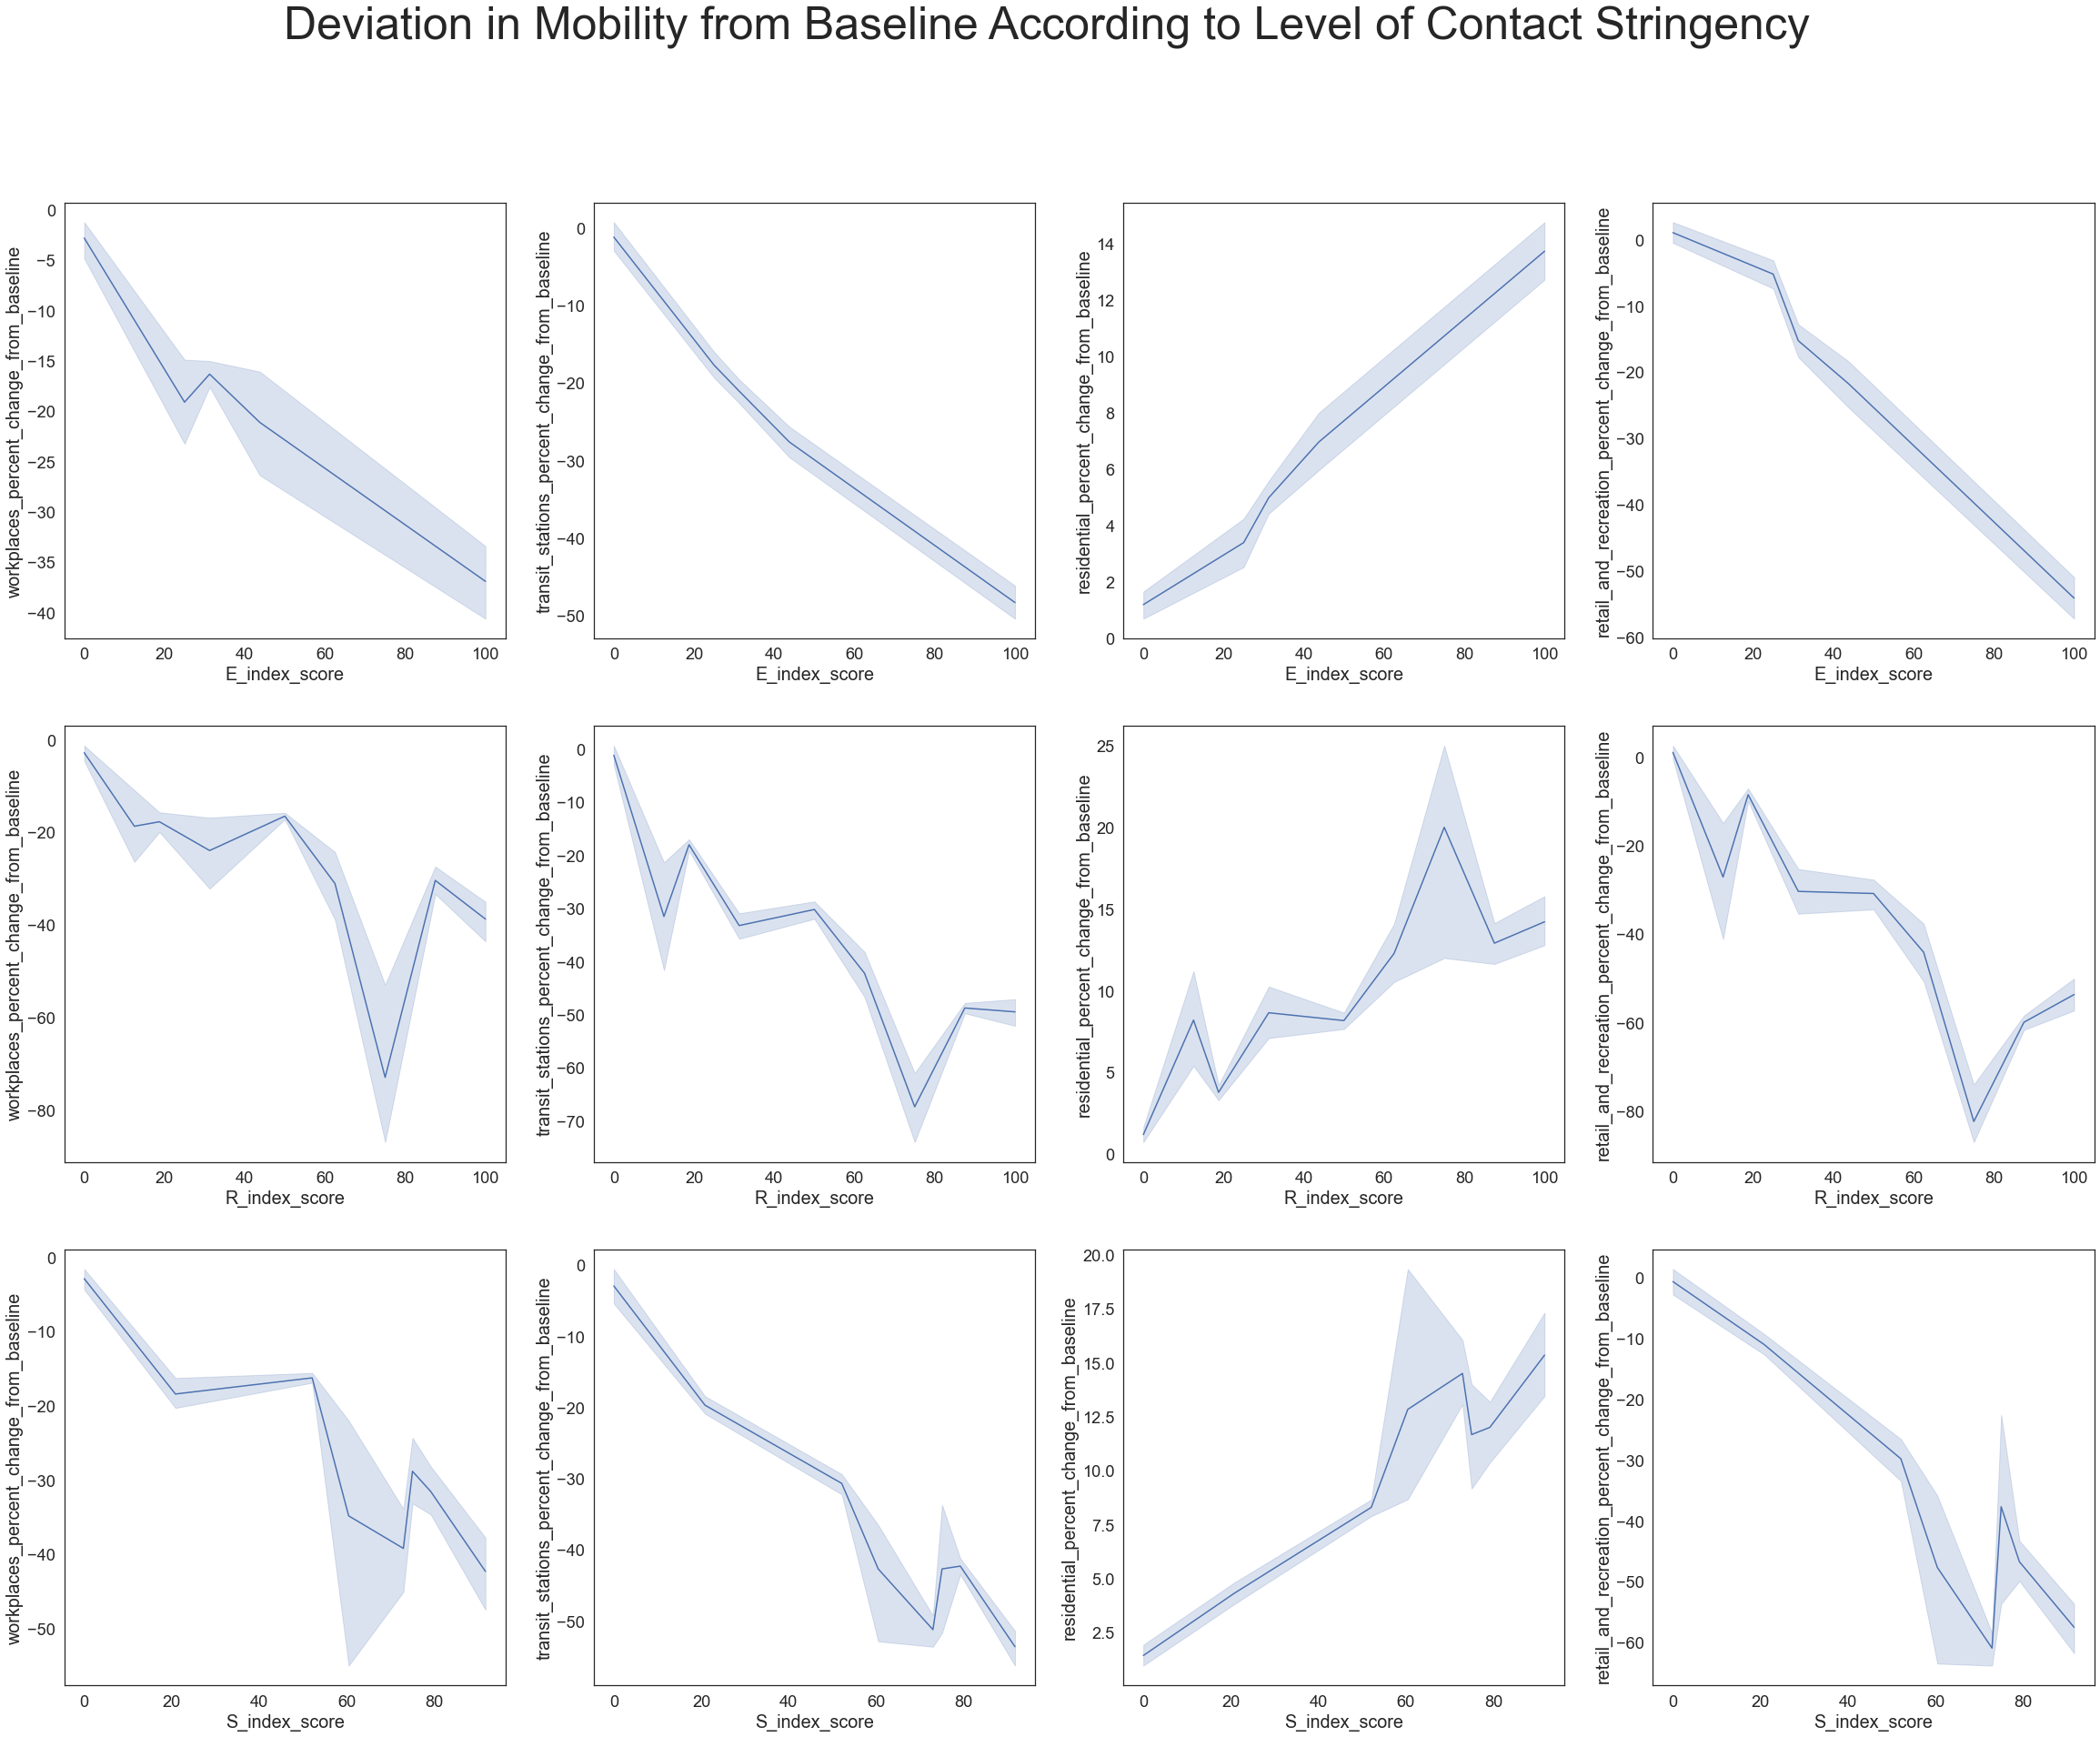

In [16]:
sns.set(font_scale=1.65, style="white")
count=1
plt.subplots(figsize=(40, 30))
plt.suptitle('Deviation in Mobility from Baseline According to Level of Contact Stringency', size=50)
for i in scores:
    for t in mobility:
        plt.subplot(3,4,count)
        sns.lineplot(x=df_visuals[i], y=df_visuals[t])
        count+=1
plt.show()

### 4.4. Visualisations of Stringency Index vs Mobility 

In [17]:
for i, (baseline,title,colour) in enumerate (zip(baselines,titles_2,colours)):
    fig=px.line(df_visuals, x='date', y=[baseline,'stringency_index_score'],
                 title="Comparison of %s Mobility Trend with Aggregate Stringency Index over Time" % title,
                 width=1200, height=600,
                 color_discrete_sequence=[colour, "#3C2030"],
                 template='simple_white')
    fig.update_layout(xaxis_title="Date",
                       yaxis_title="Baseline Change for %s Mobility, in %%" % title,
                       legend_title="Legend:",
                       title_x=0.5,
                       title_font=dict(size=20),
                       legend=dict(y=0.75,x=1))
    fig.show()

### 4.5. Visualisation of Education Sub Index Score vs Mobility

In [18]:
fig = px.line(df_visuals, x='date', y=education_mobility, 
              title='Changes in Mobility vs. School Stringency Index over Time',width=1200, height=600,
              color_discrete_sequence=px.colors.qualitative.Antique)
fig.update_layout(xaxis_title="Date",
                  yaxis_title="Baseline Changes for Various Mobility Types, in %",
                  legend_title="Legend:",
                  title_x=0.5,title_font=dict(size=20),
                  legend=dict(y=0.85,x=1),
                  template='simple_white')
fig.show()

### 4.6. Visualisations of New Covid Cases/New Covid Deaths vs Stringency Index

In [19]:
for i, (corona_var,title,axis,colour) in enumerate (zip(corona_vars,titles_3,axes,colours)):
    subfig = make_subplots(specs=[[{"secondary_y": True}]])
    fig = px.bar(df_visuals, x='date', y='stringency_index_score', color='stringency_index_score')
    figi = px.line(df_visuals, x='date', y=corona_var, color_discrete_sequence=[colour])
    figi.update_traces(yaxis="y2")
    subfig.add_traces(fig.data + figi.data)
    subfig.update_layout(width=1200, height=600, 
                         title= "Comparing %s with Aggregate Stringency Index over Time" % title, 
                         title_x=0.5,title_font=dict(size=20))
    subfig.update_layout(yaxis=dict(range=[0,100]), yaxis2= axis)
    subfig.layout.xaxis.title="Date"
    subfig.layout.yaxis.title="Aggregate Stringency Index"
    subfig.layout.yaxis2.title="%s" % title
    subfig.layout.template='simple_white'
    subfig.show()